## TC 5033
## Deep Learning
## Transformers

#### Activity 4: Implementing a Translator

- Objective

To understand the Transformer Architecture by Implementing a translator.

- Instructions

    This activity requires submission in teams. While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Follow the provided code. The code already implements a transformer from scratch as explained in one of [week's 9 videos](https://youtu.be/XefFj4rLHgU)

    Since the provided code already implements a simple translator, your job for this assignment is to understand it fully, and document it using pictures, figures, and markdown cells.  You should test your translator with at least 10 sentences. The dataset used for this task was obtained from [Tatoeba, a large dataset of sentences and translations](https://tatoeba.org/en/downloads).
  
- Evaluation Criteria

    - Code Readability and Comments
    - Traning a translator
    - Translating at least 10 sentences.

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.



In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd

In [3]:
#tsv_file='/content/drive/MyDrive/MLops/English-Spanish.tsv'
tsv_file='./English-Spanish.tsv'
# reading given tsv file
# Seperate with a tab '\t'
csv_table=pd.read_table(tsv_file,sep='\t')
# converting tsv file into csv and save it.
#csv_table.to_csv('/content/drive/MyDrive/MLops/English-Spanish.csv',index=False)
csv_table.to_csv('./English-Spanish.csv',index=False)

#### Script to convert csv to text file

In [4]:
#This script requires to convert the TSV file to CSV
# easiest way is to open it in Calc or excel and save as csv
#PATH = '/content/drive/MyDrive/MLops/English-Spanish.csv'
PATH = './English-Spanish.csv'
import pandas as pd
# This line was commented because the file is already CSV the separator is a comma ',' not a tab '\t'
#df = pd.read_csv(PATH, sep='\t')
df = pd.read_csv(PATH, sep=',')


In [5]:
df

,1276,Let's try something.,2481,¡Intentemos algo!
0,1277,I have to go to sleep.,2482,Tengo que irme a dormir.
1,1280,Today is June 18th and it is Muiriel's birthday!,2485,¡Hoy es 18 de junio y es el cumpleaños de Muir...
2,1280,Today is June 18th and it is Muiriel's birthday!,1130137,¡Hoy es el 18 de junio y es el cumpleaños de M...
3,1282,Muiriel is 20 now.,2487,"Ahora, Muiriel tiene 20 años."
4,1282,Muiriel is 20 now.,1130133,Muiriel tiene 20 años ahora.
...,...,...,...,...
266361,12842556,I am passionate about learning other languages.,5716479,Me apasiona conocer otras lenguas.
266362,12843650,"According to the Talmud, God visits 18,000 wor...",10372601,"Según el Talmud judío, Dios visita 18 000 mund..."
266363,12843605,"It's very windy this morning, isn't it?",967598,"Esta mañana hace mucho viento, ¿no?"
266364,12843600,Even the smallest nation fights for its rights.,1457398,Incluso la nación más pequeña lucha por sus de...


In [6]:
eng_spa_cols = df.iloc[:, [1, 3]]
# Separate the sentence in english, column 1 and the sentence in spanish column 3.
eng_spa_cols['length'] = eng_spa_cols.iloc[:, 0].str.len()
# sort sentences by length on the columns
eng_spa_cols = eng_spa_cols.sort_values(by='length')
eng_spa_cols = eng_spa_cols.drop(columns=['length'])
# Save the filte in txt only sentences.
#output_file_path = '/content/drive/MyDrive/MLops/eng-spa.txt'
output_file_path = './eng-spa.txt'
eng_spa_cols.to_csv(output_file_path, sep='\t', index=False, header=False)

/tmp/ipykernel_48016/3113855809.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_spa_cols['length'] = eng_spa_cols.iloc[:, 0].str.len()


## Transformer - Attention is all you need

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import math
import numpy as np
import re

torch.manual_seed(23)

In [8]:
# Detect if there is a GPU connected.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
MAX_SEQ_LEN = 128 # Max number of the input

## Positional encoding

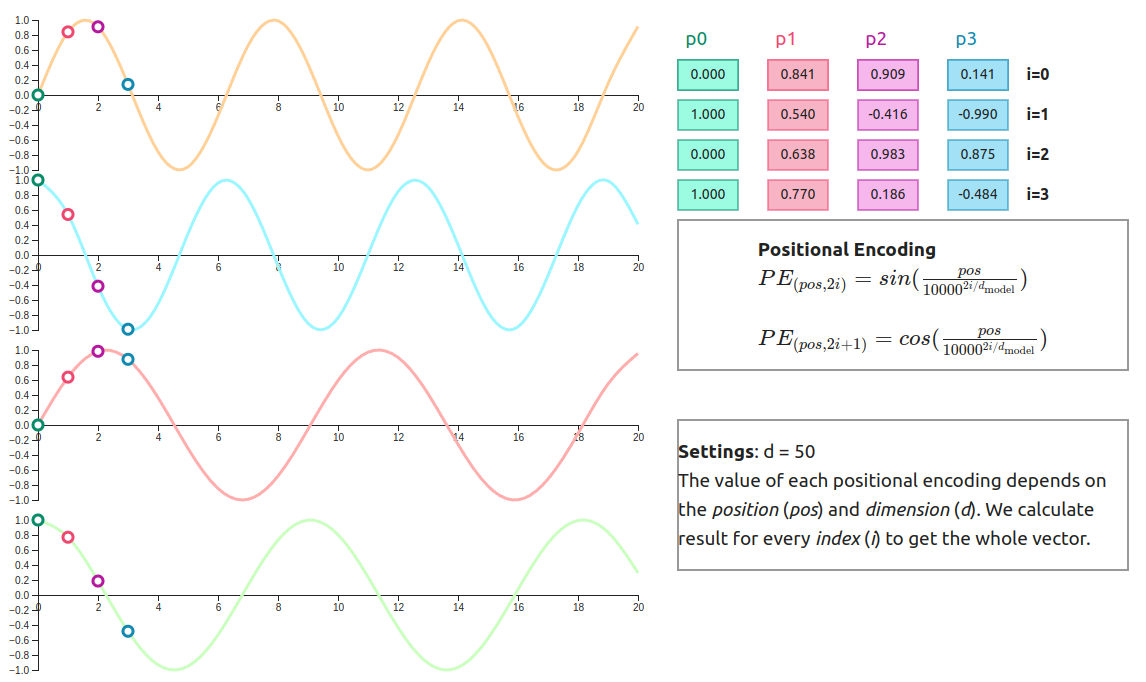

### With the positional encoding the sequence of the input sentence will always be the same. The translator will keep the same context through all the process.

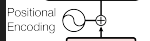

In [10]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_len = MAX_SEQ_LEN):
        super().__init__()
        self.pos_embed_matrix = torch.zeros(max_seq_len, d_model, device=device)
        token_pos = torch.arange(0, max_seq_len, dtype = torch.float).unsqueeze(1)
        # The following line adds the position with math.log() to keep the input sequence
        # This for all the embeedings.
        div_term = torch.exp(torch.arange(0, d_model, 2).float()
                             * (-math.log(10000.0)/d_model))
        self.pos_embed_matrix[:, 0::2] = torch.sin(token_pos * div_term)
        self.pos_embed_matrix[:, 1::2] = torch.cos(token_pos * div_term)
        self.pos_embed_matrix = self.pos_embed_matrix.unsqueeze(0).transpose(0,1)

    def forward(self, x):
#         print(self.pos_embed_matrix.shape)
#         print(x.shape)
        return x + self.pos_embed_matrix[:x.size(0), :]

## The transformer to code.

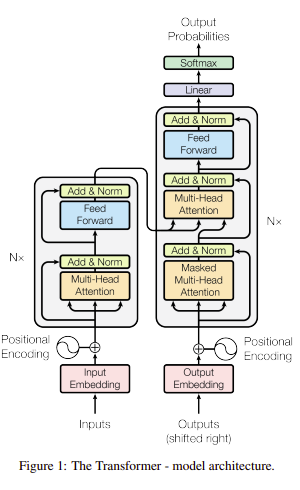

### Multihead attention
Each token will calculate the relationship it has with the other tokens in the sentence or input words.


There are 3 outputs, Q (the query or input token), K (the output key with which the other Q will be compared) and V (key of the output value)


The dot product of the output of token_n = W_q·Wk_n
Where Wk_n are the keys generated for each input token.


This generates different representations of the same token relative to all other tokens.

Attention(Q, K, V ) = softmax(QKT
√
dk
)V

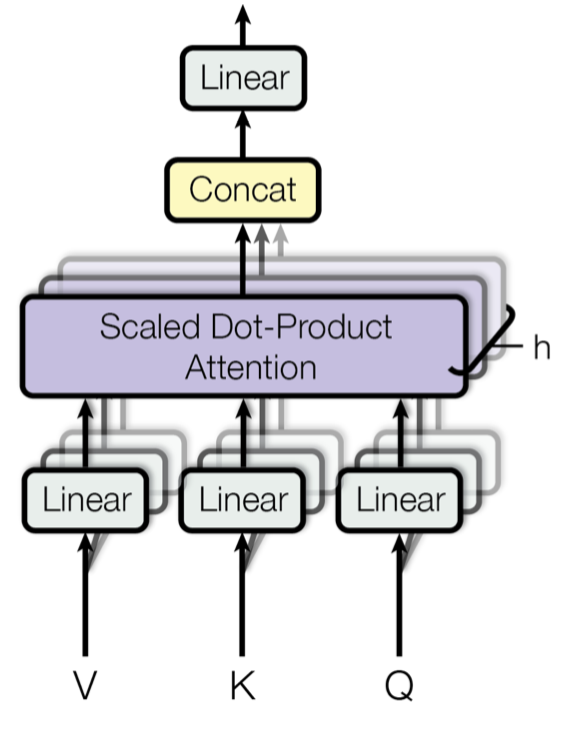

* The result of the sum of the dot products goes through a SOFTMAX function so that the output has a statistical representation where the sum of all the tokens results in 1.
* In the end this process results in an attention vector for each token.

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model = 512, num_heads = 8):
        super().__init__()
        assert d_model % num_heads == 0, 'Embedding size not compatible with num heads'

        self.d_v = d_model // num_heads
        self.d_k = self.d_v
        self.num_heads = num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask = None):
        batch_size = Q.size(0)
        '''
        Q, K, V -> [batch_size, seq_len, num_heads*d_k]
        after transpose Q, K, V -> [batch_size, num_heads, seq_len, d_k]
        '''
        #
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )

        weighted_values, attention = self.scale_dot_product(Q, K, V, mask)
        weighted_values = weighted_values.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads*self.d_k)
        weighted_values = self.W_o(weighted_values)

        return weighted_values, attention


    def scale_dot_product(self, Q, K, V, mask = None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = F.softmax(scores, dim = -1)
        weighted_values = torch.matmul(attention, V)

        return weighted_values, attention


class PositionFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))

class EncoderSubLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.droupout1 = nn.Dropout(dropout)
        self.droupout2 = nn.Dropout(dropout)

    def forward(self, x, mask = None):
        attention_score, _ = self.self_attn(x, x, x, mask)
        x = x + self.droupout1(attention_score)
        x = self.norm1(x)
        x = x + self.droupout2(self.ffn(x))
        return self.norm2(x)

class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([EncoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class DecoderSubLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, encoder_output, target_mask=None, encoder_mask=None):
        attention_score, _ = self.self_attn(x, x, x, target_mask)
        x = x + self.dropout1(attention_score)
        x = self.norm1(x)

        encoder_attn, _ = self.cross_attn(x, encoder_output, encoder_output, encoder_mask)
        x = x + self.dropout2(encoder_attn)
        x = self.norm2(x)

        ff_output = self.feed_forward(x)
        x = x + self.dropout3(ff_output)
        return self.norm3(x)

class Decoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, encoder_output, target_mask, encoder_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, target_mask, encoder_mask)
        return self.norm(x)

## The embeddings are this part of the transformer

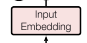

In [ ]:
class Transformer(nn.Module):
    # d_model size of the embedings
    # num_heads parallel heads running
    # d_ff feed forward neuronal networks 
    # num_layers the the encoder and decoder
    # input_vocab_size size of the vocabulary of the source language ENG
    # target_vocab_size spanish vocabulary
    # max_len it the max input
    # droput 
    def __init__(self, d_model, num_heads, d_ff, num_layers,
                 input_vocab_size, target_vocab_size,
                 max_len=MAX_SEQ_LEN, dropout=0.1):
        super().__init__()
        # Create the embeddings for the Vocabulary
        # is the definition of the small neuronal network for each token.
        # The size defines the input layer of the neuronal network
        
        self.encoder_embedding = nn.Embedding(input_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_embedding = PositionalEmbedding(d_model, max_len)
        self.encoder = Encoder(d_model, num_heads, d_ff, num_layers, dropout)
        self.decoder = Decoder(d_model, num_heads, d_ff, num_layers, dropout)
        self.output_layer = nn.Linear(d_model, target_vocab_size)

    def forward(self, source, target):
        # Encoder mask
        source_mask, target_mask = self.mask(source, target)
        # Embedding and positional Encoding
        source = self.encoder_embedding(source) * math.sqrt(self.encoder_embedding.embedding_dim)
        source = self.pos_embedding(source)
        # Encoder
        encoder_output = self.encoder(source, source_mask)

        # Decoder embedding and postional encoding
        target = self.decoder_embedding(target) * math.sqrt(self.decoder_embedding.embedding_dim)
        target = self.pos_embedding(target)
        # Decoder
        output = self.decoder(target, encoder_output, target_mask, source_mask)

        return self.output_layer(output)


    # Set the attention only on the token that you want to predict and no to the following tokens or padding tokens
    # [{me} gusta la inteligencia artificial]
    # focues on the prediction of me.
    def mask(self, source, target):
        source_mask = (source != 0).unsqueeze(1).unsqueeze(2)
        target_mask = (target != 0).unsqueeze(1).unsqueeze(2)
        size = target.size(1)
        no_mask = torch.tril(torch.ones((1, size, size), device=device)).bool()
        target_mask = target_mask & no_mask
        return source_mask, target_mask


#### Simple test

In [13]:
seq_len_source = 10
seq_len_target = 10
batch_size = 2
input_vocab_size = 50
target_vocab_size = 50

source = torch.randint(1, input_vocab_size, (batch_size, seq_len_source))
target = torch.randint(1, target_vocab_size, (batch_size, seq_len_target))

In [14]:
d_model = 512 # Number of entries for the mini neuronal network created for each token.  
num_heads = 8 # This is the main idea of the MultiHead attention.
d_ff = 2048   # Numero maximo de tokens de entrada
num_layers = 6

model = Transformer(d_model, num_heads, d_ff, num_layers,
                  input_vocab_size, target_vocab_size,
                  max_len=MAX_SEQ_LEN, dropout=0.1)

model = model.to(device)
source = source.to(device)
target = target.to(device)

In [15]:
output = model(source, target)

In [16]:
# Expected output shape -> [batch, seq_len_target, target_vocab_size] i.e. [2, 10, 50]
print(f'ouput.shape {output.shape}')

ouput.shape torch.Size([2, 10, 50])


### Translator Eng-Spa

In [17]:
#PATH = '/content/drive/MyDrive/MLops/eng-spa.txt'
PATH = './eng-spa.txt'

In [18]:
# Use the txt file where only the english and spanish sentence is save in rows.
# Identify the english and spanish sentence with the tab character '\t'
with open(PATH, 'r', encoding='utf-8') as f:
    lines = f.readlines()
eng_spa_pairs = [line.strip().split('\t') for line in lines if '\t' in line]

In [19]:
eng_spa_pairs[:10]

[['So?', '¿Y qué?'],
 ['Hi.', '¡Hola!'],
 ['Ah!', '¡Anda!'],
 ['Ow!', '¡Ay!'],
 ['Go.', 'Váyase.'],
 ['Go!', '¡Ve!'],
 ['Go!', '¡Sal!'],
 ['Hi.', 'Hola.'],
 ['Go!', '¡Ya!'],
 ['No.', 'No.']]

In [20]:
eng_sentences = [pair[0] for pair in eng_spa_pairs]
spa_sentences = [pair[1] for pair in eng_spa_pairs]

In [21]:
print(eng_sentences[:10])
print(spa_sentences[:10])


['So?', 'Hi.', 'Ah!', 'Ow!', 'Go.', 'Go!', 'Go!', 'Hi.', 'Go!', 'No.']
['¿Y qué?', '¡Hola!', '¡Anda!', '¡Ay!', 'Váyase.', '¡Ve!', '¡Sal!', 'Hola.', '¡Ya!', 'No.']


In [22]:
# Clean up the special characters. Replace the special characers with the english version.
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[á]+", "a", sentence)
    sentence = re.sub(r"[é]+", "e", sentence)
    sentence = re.sub(r"[í]+", "i", sentence)
    sentence = re.sub(r"[ó]+", "o", sentence)
    sentence = re.sub(r"[ú]+", "u", sentence)
    sentence = re.sub(r"[^a-z]+", " ", sentence)
    sentence = sentence.strip()
    # Add to each sencente the start of the sequence(SOS) and the en of sequence(EOS).
    sentence = '<sos> ' + sentence + ' <eos>'
    return sentence

In [23]:
s1 = '¿Hola @ cómo estás? 123'

In [24]:
print(s1)
print(preprocess_sentence(s1))

¿Hola @ cómo estás? 123
<sos> hola como estas <eos>


In [25]:
eng_sentences = [preprocess_sentence(sentence) for sentence in eng_sentences]
spa_sentences = [preprocess_sentence(sentence) for sentence in spa_sentences]

In [26]:
spa_sentences[:10]

['<sos> y que <eos>',
 '<sos> hola <eos>',
 '<sos> anda <eos>',
 '<sos> ay <eos>',
 '<sos> vayase <eos>',
 '<sos> ve <eos>',
 '<sos> sal <eos>',
 '<sos> hola <eos>',
 '<sos> ya <eos>',
 '<sos> no <eos>']

In [27]:
# Seperate all the word in the sentences, create tokens.
def build_vocab(sentences):
    words = [word for sentence in sentences for word in sentence.split()]
    word_count = Counter(words)
    # Sort word with the repetition number.
    sorted_word_counts = sorted(word_count.items(), key=lambda x:x[1], reverse=True)
    # with the following line we can get a index with its word. Dictionary
    word2idx = {word: idx for idx, (word, _) in enumerate(sorted_word_counts, 2)}
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    # with the following line we can get a word with its index.
    idx2word = {idx: word for word, idx in word2idx.items()}
    return word2idx, idx2word

In [28]:
# Create englilsh dictionary
eng_word2idx, eng_idx2word = build_vocab(eng_sentences)
# Create espanish dictionary
spa_word2idx, spa_idx2word = build_vocab(spa_sentences)
# Show vocabulary length
eng_vocab_size = len(eng_word2idx)
spa_vocab_size = len(spa_word2idx)

In [29]:
print(eng_vocab_size, spa_vocab_size)

27650 46929


In [30]:
class EngSpaDataset(Dataset):
    def __init__(self, eng_sentences, spa_sentences, eng_word2idx, spa_word2idx):
        self.eng_sentences = eng_sentences
        self.spa_sentences = spa_sentences
        self.eng_word2idx = eng_word2idx
        self.spa_word2idx = spa_word2idx

    def __len__(self):
        return len(self.eng_sentences)
    # This will enable us to get the elements from our vocabulary
    # Will be use to generate batches specified.
    def __getitem__(self, idx):
        eng_sentence = self.eng_sentences[idx]
        spa_sentence = self.spa_sentences[idx]
        # return tokens idxs
        eng_idxs = [self.eng_word2idx.get(word, self.eng_word2idx['<unk>']) for word in eng_sentence.split()]
        spa_idxs = [self.spa_word2idx.get(word, self.spa_word2idx['<unk>']) for word in spa_sentence.split()]
        # Return tensor for the english and spanish vocabulary
        return torch.tensor(eng_idxs), torch.tensor(spa_idxs)

In [31]:
def collate_fn(batch):
    # Receives eng & spanish batches
    eng_batch, spa_batch = zip(*batch)
    # Truncate the sequence for the max sequence length.
    eng_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in eng_batch]
    spa_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in spa_batch]
    # Paddings for the sequences.
    eng_batch = torch.nn.utils.rnn.pad_sequence(eng_batch, batch_first=True, padding_value=0)
    spa_batch = torch.nn.utils.rnn.pad_sequence(spa_batch, batch_first=True, padding_value=0)
    return eng_batch, spa_batch


In [32]:
def train(model, dataloader, loss_function, optimiser, epochs):
    model.train()
    # For each epoch we will have a batch of the english and spanish
    # vocabulary.
    for epoch in range(epochs):
        total_loss = 0
        for i, (eng_batch, spa_batch) in enumerate(dataloader):
            # The device is detected at the begining is GPU or CPU
            eng_batch = eng_batch.to(device)
            spa_batch = spa_batch.to(device)
            # Decoder preprocessing
            # The input is the sentence to translate
            # This will select all the word expect the last one, the last one we want the model to predict.
            target_input = spa_batch[:, :-1]
            # The output is the raduction.
            # This is the expected value following value.
            # I the input is ME the expected value should be gusta.
            target_output = spa_batch[:, 1:].contiguous().view(-1)
            # Zero grads
            # Pytorch function, gradients are added so we need to set to 0.
            optimiser.zero_grad()
            # run model
            # Receives source the english batch, the target is the input sentence.
            output = model(eng_batch, target_input)
            # Make the output compatible with the loss function.
            output = output.view(-1, output.size(-1))
            loss = loss_function(output, target_output)
            # gradient and update parameters
            loss.backward()
            optimiser.step()
            total_loss += loss.item()

        avg_loss = total_loss/len(dataloader)
        print(f'Epoch: {epoch}/{epochs}, Loss: {avg_loss:.4f}')



In [33]:
BATCH_SIZE = 45
dataset = EngSpaDataset(eng_sentences, spa_sentences, eng_word2idx, spa_word2idx)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [34]:
model = Transformer(d_model=256, num_heads=4, d_ff=2056, num_layers=6,
                    input_vocab_size=eng_vocab_size, target_vocab_size=spa_vocab_size,
                    max_len=MAX_SEQ_LEN, dropout=0.1)

In [35]:
model = model.to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimiser = optim.Adam(model.parameters(), lr=0.0001)


In [36]:
train(model, dataloader, loss_function, optimiser, epochs = 10)

Epoch: 0/10, Loss: 4.0734
Epoch: 1/10, Loss: 2.6395
Epoch: 2/10, Loss: 2.1240
Epoch: 3/10, Loss: 1.8041
Epoch: 4/10, Loss: 1.5733
Epoch: 5/10, Loss: 1.3891
Epoch: 6/10, Loss: 1.2398
Epoch: 7/10, Loss: 1.1118
Epoch: 8/10, Loss: 1.0012
Epoch: 9/10, Loss: 0.9056


In [37]:
import joblib 
filename = './joblib_model_multihead_attention.sav'
joblib.dump(model, filename)

['./joblib_model_multihead_attention.sav']

In [38]:
def sentence_to_indices(sentence, word2idx):
    return [word2idx.get(word, word2idx['<unk>']) for word in sentence.split()]

def indices_to_sentence(indices, idx2word):
    return ' '.join([idx2word[idx] for idx in indices if idx in idx2word and idx2word[idx] != '<pad>'])

def translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    model.eval()
    sentence = preprocess_sentence(sentence)
    input_indices = sentence_to_indices(sentence, eng_word2idx)
    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device)

    # Initialize the target tensor with <sos> token
    tgt_indices = [spa_word2idx['<sos>']]
    tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(max_len):
            output = model(input_tensor, tgt_tensor)
            output = output.squeeze(0)
            next_token = output.argmax(dim=-1)[-1].item()
            tgt_indices.append(next_token)
            tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)
            if next_token == spa_word2idx['<eos>']:
                break

    return indices_to_sentence(tgt_indices, spa_idx2word)

In [40]:
def evaluate_translations(model, sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    for sentence in sentences:
        translation = translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len, device)
        print(f'Input sentence: {sentence}')
        print(f'Traducción: {translation}')
        print()

# Example sentences to test the translator
test_sentences = [
    "Good evening, how are you",
    "I love artificial intelligence.",
    "I'm learning multihead attention",
    "How is the weather in seattle?",
    "Where can we sleep tonigth",
    "Do you know a good restaurant around here?",
    "What are you doing here?",
    "Whats wrong with you?",
    "I can go to work I'm blue",
    "What kind of food do you like?",
]

# Assuming the model is trained and loaded
# Set the device to 'cpu' or 'cuda' as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluate translations
evaluate_translations(model, test_sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device=device)


Input sentence: Good evening, how are you
Traducción: <sos> buenas tardes como estas <eos>

Input sentence: I love artificial intelligence.
Traducción: <sos> me encanta la inteligencia artificial <eos>

Input sentence: I'm learning multihead attention
Traducción: <sos> estoy aprendiendo atencion <eos>

Input sentence: How is the weather in seattle?
Traducción: <sos> como esta el clima en seattle <eos>

Input sentence: Where can we sleep tonigth
Traducción: <sos> donde podemos dormir <eos>

Input sentence: Do you know a good restaurant around here?
Traducción: <sos> conoce algun buen restaurante por aqui <eos>

Input sentence: What are you doing here?
Traducción: <sos> que haces aqui <eos>

Input sentence: Whats wrong with you?
Traducción: <sos> te has equivocado contigo <eos>

Input sentence: I can go to work I'm blue
Traducción: <sos> puedo ir al trabajo azul estoy de trabajo <eos>

Input sentence: What kind of food do you like?
Traducción: <sos> que tipo de comida te gusta <eos>



In [44]:
print(model.eval())


Transformer(
  (encoder_embedding): Embedding(27650, 256)
  (decoder_embedding): Embedding(46929, 256)
  (pos_embedding): PositionalEmbedding()
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderSubLayer(
        (self_attn): MultiHeadAttention(
          (W_q): Linear(in_features=256, out_features=256, bias=True)
          (W_k): Linear(in_features=256, out_features=256, bias=True)
          (W_v): Linear(in_features=256, out_features=256, bias=True)
          (W_o): Linear(in_features=256, out_features=256, bias=True)
        )
        (ffn): PositionFeedForward(
          (linear1): Linear(in_features=256, out_features=2056, bias=True)
          (linear2): Linear(in_features=2056, out_features=256, bias=True)
        )
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (droupout1): Dropout(p=0.1, inplace=False)
        (droupout2): Dropout(p=0.1, inplace=False)
   